In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm, metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, GroupKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_error, roc_auc_score, precision_score, make_scorer
from sklearn.linear_model import LassoCV, Lasso, LassoLarsIC, ElasticNet, LassoLarsCV
from sklearn.externals import joblib
from scipy.stats import randint as sp_randint
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
%matplotlib inline
import biom
import calour as ca
from scipy import stats
import scipy
import pickle
import time
import math
import inspect
pd.set_option('display.max_rows', 10000)

# Importing data, no TSS normalization performed here

In [3]:
allMetab = ca.read_amplicon('PMI_MS1_FeatureTable_Normalized.biom','pmi3_metab_meta.txt', min_reads=1, normalize = None)

## Remove controls and samples clustering with controls on PCoA

In [4]:
allMetab = allMetab.filter_samples('control', 'n')
allMetab = allMetab.filter_samples('pcoa_removals', 'n')
allMetab.sample_metadata.description.value_counts()

skin.hip    746
soil.hip    744
Name: description, dtype: int64

## Seperate general model validation bodies and training bodies

In [5]:
allMetab_train = allMetab.filter_samples('validation_set', 'n')
allMetab_val = allMetab.filter_samples('validation_set', 'y')

In [6]:
allMetab_train.sample_metadata.description.value_counts()

skin.hip    497
soil.hip    493
Name: description, dtype: int64

In [7]:
allMetab_val.sample_metadata.description.value_counts()

soil.hip    251
skin.hip    249
Name: description, dtype: int64

In [8]:
#allMetab.sample_metadata.columns

In [9]:
#dir(allMetab)

In [10]:
#print(allMetab.feature_metadata)

# General Model of All Facilites, Samples, and Season using ADD 0C as Response and Adding Metadata to Determine Metadata Importance

In [8]:
allMetab_train_meta = allMetab_train.add_sample_metadata_as_features(['season','facility','sample_type','avg_percent_humidity','total_precipitation_cm'])

AttributeError: 'AmpliconExperiment' object has no attribute 'add_sample_metadata_as_features'

In [14]:
gkf = GroupKFold(6)

X_train = allMetab_train_meta.data
y_train = allMetab_train_meta.sample_metadata['add_0c']
y_train = (y_train.astype(float))

groups = allMetab_train_meta.sample_metadata['subjectID']

# Tested this param grid on Summit to expand hyperparameter tuning
#param_grid = {"max_depth": [4, 8, 16, None],
#              "max_features": ['sqrt', 'log2', 0.1],
#              "min_samples_split": [0.001, 0.01, 0.1],
#              "min_weight_fraction_leaf": [0.0001, 0.001, 0.01],
#              "bootstrap": [True, False]}
# It provided this best model:

# Takes too long to run on local computer; will need to run then import model from Summit
param_grid = {"max_depth": [8],
          "max_features": [0.1],
          "min_samples_split": [0.001],
          "min_weight_fraction_leaf": [0.01],
          "bootstrap": [False]}
rf = RandomForestRegressor(n_estimators=10, random_state=999, criterion='mae')
gs = GridSearchCV(rf, param_grid=param_grid, cv=gkf.split(X_train, y_train, groups), scoring='neg_mean_absolute_error', n_jobs=-3)

In [15]:
gs.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x122f7b8d0>,
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mae', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_es...ne,
                                             oob_score=False, random_state=999,
                                             verbose=0, warm_start=Fa

In [ ]:
print(gs.best_params_)

In [16]:
print('The best mean absolute error is', round(-gs.best_score_,2))

The best mean absolute error is 78.66


In [17]:
joblib.dump(gs.best_estimator_, 'models/PMI3_allMetab_meta_general.pkl')

['models/PMI3_allMetab_meta_general.pkl']

In [18]:
model_PMI3_allMetab_meta_general = joblib.load('models/PMI3_allMetab_meta_general.pkl')

In [19]:
model_PMI3_allMetab_meta_general

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                      max_depth=8, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=0.001, min_weight_fraction_leaf=0.01,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=999, verbose=0, warm_start=False)

## Recursive Feature Elimination 

### Uses the best estimator from the above model and performs 5% removal recursive steps

In [20]:
rfecv = RFECV(estimator=model_PMI3_allMetab_meta_general, step=0.05, cv=list(gkf.split(X_train, y_train, groups)), scoring='neg_mean_absolute_error', n_jobs=-3)

In [21]:
# Likely need to run on Summit
rfecv.fit(X_train, y_train)

RFECV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129...
                                      max_features=0.1, max_leaf_nodes=None,
                                      max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1,
                                      min_samples_split=0.001,
            

In [20]:
print("Number of steps performed: %d" % len(rfecv.grid_scores_))
print("Optimal number of features : %d" % rfecv.n_features_)
print("The best mean absolute error is: %d" % -(max(rfecv.grid_scores_)))

Number of steps performed: 22
Optimal number of features : 2871
The best mean absolute error is: 77


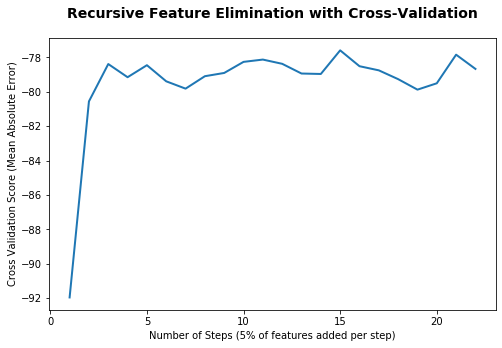

In [21]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Number of Steps (5% of features added per step)")
plt.ylabel("Cross Validation Score (Mean Absolute Error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=2)
plt.savefig('figures/general_model_meta_rfecv.png')

In [22]:
# Saves the estimator fit on the reduced dataset (i.e. the model created from optimal features)
joblib.dump(rfecv.estimator_, 'models/PMI3_allMetab_meta_general_rfecv.pkl')
model_PMI3_allMetab_meta_general_rfecv = joblib.load('models/PMI3_allMetab_meta_general_rfecv.pkl')
model_PMI3_allMetab_meta_general_rfecv

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

### Determine important features after RFECV

In [23]:
importances = model_PMI3_allMetab_meta_general_rfecv.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_PMI3_allMetab_meta_general_rfecv.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = allMetab_train_meta.feature_metadata
np.savetxt("feature_metadata/general_all_feature_metadata_meta_rfecv.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
general_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    general_importances += (allMetab_train_meta.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(allMetab_train_meta.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X282.27712487174_7.23317913752913	0.10361088637390861
2. X300.288733742453_4.75564670033669	0.06653575109405432
3. X270.278182922606_7.326998937583	0.04914929349304647
4. X269.210000802471_5.71957425343018	0.04734332241490429
5. X326.340475453795_8.1965404290429	0.04592491101614339
6. X338.340824997771_8.0974091286307	0.039672071016086004
7. X283.261846131269_6.46965379294957	0.03498607931690756
8. X265.251786739268_6.47317440898345	0.032267650340121676
9. X296.293165677331_7.47388266068758	0.029759624850633642
10. facility=SHSU	0.0273679950487943
11. X336.324589233398_6.68424266666666	0.02370124834115355
12. X283.262279643568_7.70306372739017	0.019242005811699943
13. X255.231118649466_7.12408511166254	0.01876104562919958
14. X256.262006528934_7.07576439121756	0.017168341651793425
15. X247.16604482941_9.94318677098151	0.011946484552233818
16. X305.24440751779_7.72425823878984	0.010736602258679903
17. X237.220427340176_7.13047029360967	0.010437539529621499
18.

In [24]:
# make sure shape is right
print("Number of features present:", int(len(general_importances)/2))
general_importances_df = pd.DataFrame(np.array(general_importances).reshape(int(len(general_importances)/2),2))

np.savetxt("importances/general_all_importances_meta_rfecv.csv", general_importances_df, delimiter=",", fmt='%s')

Number of features present: 2871


In [25]:
# Removes the unimportant features from X
# Will need to use this to remove unwanted features from validation set otherwise you get shape error
# Though you shouldn't have to perform this on the training set, this is just an example
# X_train = rfecv.transform(X_train)

### Testing on validaiton set

In [26]:
allMetab_val_meta = allMetab_val.add_sample_metadata_as_features(['season','facility','sample_type','avg_percent_humidity','total_precipitation_cm'])

X_val = rfecv.transform(allMetab_val_meta.data) #removing the unimportant features from X as determined by RFECV
y_val = allMetab_val_meta.sample_metadata['add_0c']
y_val = (y_val.astype(float))


yhat = model_PMI3_allMetab_meta_general_rfecv.predict(X_val)

# cross-model error (cross-experiment error)
MAE = mean_absolute_error(y_val, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_PMI3_allMetab_meta_general_rfecv.score(X_val,y_val),2))

Mean Absolute Error: 67.31 ADD
Coefficient of determination R^2 of the prediction: 0.59


/Users/Zach/miniconda3/envs/ml/lib/python3.7/site-packages/calour/training.py:130: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  new.feature_metadata = pd.concat([pd.DataFrame(index=vec.get_feature_names()), new.feature_metadata])


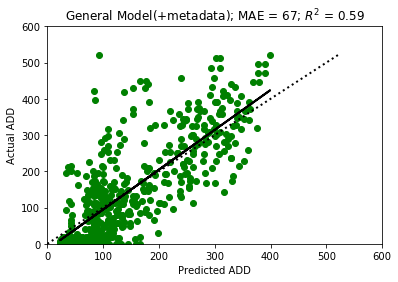

In [27]:
plt.scatter(yhat, y_val, color = 'g')
lower = np.min(np.concatenate([y_val, yhat]))
upper = np.max(np.concatenate([y_val, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_val)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('General Model(+metadata); MAE = %d; $R^2$ = %.2f' %(MAE,round(model_PMI3_allMetab_meta_general_rfecv.score(X_val,y_val),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/general_model_validation_meta.png')

# General Model of All Facilites, Samples, and Season using ADD 0C as Response WITHOUT metadata

In [8]:
gkf = GroupKFold(6)

X_train = allMetab_train.data
y_train = allMetab_train.sample_metadata['add_0c']
y_train = (y_train.astype(float))

groups = allMetab_train.sample_metadata['subjectID']

# Tested this param grid on Summit to expand hyperparameter tuning
#param_grid = {"max_depth": [4, 8, 16, None],
#              "max_features": ['sqrt', 'log2', 0.1],
#              "min_samples_split": [0.001, 0.01, 0.1],
#              "min_weight_fraction_leaf": [0.0001, 0.001, 0.01],
#              "bootstrap": [True, False]}
# It provided this best model:

# Takes too long to run on local computer; will need to run then import model from Summit
param_grid = {"max_depth": [None],
          "max_features": [0.1],
          "min_samples_split": [0.001],
          "min_weight_fraction_leaf": [0.01],
          "bootstrap": [False]}
rf = RandomForestRegressor(n_estimators=10, random_state=999, criterion='mae')
gs = GridSearchCV(rf, param_grid=param_grid, cv=gkf.split(X_train, y_train, groups), scoring='neg_mean_absolute_error', n_jobs=-3)

In [9]:
gs.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x118319a20>,
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-3,
       param_grid={'max_depth': [8], 'max_features': [0.1], 'min_samples_split': [0.001], 'min_samples_leaf': [1], 'min_weight_fraction_leaf': [0.01], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
print(gs.best_params_)

In [10]:
print('The best mean absolute error is', round(-gs.best_score_,2))

The best mean absolute error is 80.0


In [11]:
joblib.dump(gs.best_estimator_, 'models/PMI3_allMetab_general.pkl')

['models/PMI3_allMetab_general.pkl']

In [12]:
model_PMI3_allMetab_general = joblib.load('models/PMI3_allMetab_general.pkl')

In [13]:
model_PMI3_allMetab_general

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

## Recursive Feature Elimination 

### Uses the best estimator from the above model and performs 5% removal recursive steps

In [14]:
rfecv = RFECV(estimator=model_PMI3_allMetab_general, step=0.05, cv=list(gkf.split(X_train, y_train, groups)), scoring='neg_mean_absolute_error', n_jobs=-3)

In [15]:
rfecv.fit(X_train, y_train)

RFECV(cv=[(array([  0,   1, ..., 987, 988]), array([ 46,  47, ..., 983, 989])), (array([  0,   1, ..., 988, 989]), array([150, 151, ..., 981, 982])), (array([  0,   1, ..., 988, 989]), array([ 94,  95, ..., 943, 944])), (array([  3,   4, ..., 988, 989]), array([  0,   1, ..., 968, 969])), (array([  0,   1, ..., 988, 989]), array([  3,   4, ..., 971, 972])), (array([  0,   1, ..., 983, 989]), array([ 39,  40, ..., 987, 988]))],
   estimator=RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
   n_jobs=-3, scoring='neg_mean_absolute_error', step=0.05, verbose=0)

In [16]:
print("Number of steps performed: %d" % len(rfecv.grid_scores_))
print("Optimal number of features : %d" % rfecv.n_features_)
print("The best mean absolute error is: %d" % -(max(rfecv.grid_scores_)))

Number of steps performed: 21
Optimal number of features : 2420
The best mean absolute error is: 78


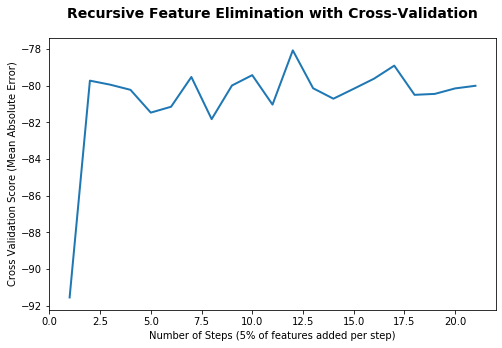

In [17]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Number of Steps (5% of features added per step)")
plt.ylabel("Cross Validation Score (Mean Absolute Error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=2)
plt.savefig('figures/general_model_rfecv.png')

In [18]:
# Saves the estimator fit on the reduced dataset (i.e. the model created from optimal features)
joblib.dump(rfecv.estimator_, 'models/PMI3_allMetab_general_rfecv.pkl')
model_PMI3_allMetab_general_rfecv = joblib.load('models/PMI3_allMetab_general_rfecv.pkl')
model_PMI3_allMetab_general_rfecv

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

### Determine important features after RFECV

In [19]:
importances = model_PMI3_allMetab_general_rfecv.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_PMI3_allMetab_general_rfecv.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = allMetab_train.feature_metadata
np.savetxt("feature_metadata/general_all_feature_metadata_rfecv.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
general_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    general_importances += (allMetab_train.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(allMetab_train.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X213.115272059585_2.94118661616161	0.11750743821048326
2. X334.095813463319_5.42592032232704	0.08894096015548261
3. X419.227672576904_3.86399479166666	0.05812312528560448
4. X221.145697021484_5.67329999999999	0.045850667381322784
5. X459.3229599577_8.07149021464647	0.04330996908755763
6. X369.296479637943_7.37038362354892	0.03620440851085052
7. X296.229463546671_5.25633057040998	0.035114209450629603
8. X802.587084562882_7.45415217391304	0.02694743176875176
9. X316.276614849384_4.32454487179487	0.02559433885682496
10. X149.059870661859_0.832815579710144	0.023531497066283175
11. X316.281931260052_3.67623235294117	0.021469614607920816
12. X352.356264209747_8.29605718749999	0.01893581436647803
13. X291.194414991013_5.24763838652482	0.016981892240120207
14. X341.162951789233_3.1995366062437	0.01447846784621401
15. X293.209694592406_5.62261263632052	0.009817453448663966
16. X334.230275934392_5.62032727272727	0.007977991063184461
17. X299.16323799465_3.4817486956521

In [20]:
# make sure shape is right
print("Number of features present:", int(len(general_importances)/2))
general_importances_df = pd.DataFrame(np.array(general_importances).reshape(int(len(general_importances)/2),2))

np.savetxt("importances/general_all_importances_rfecv.csv", general_importances_df, delimiter=",", fmt='%s')

Number of features present: 2420


### Testing on validaiton set

In [21]:
X_val = rfecv.transform(allMetab_val.data) #removing the unimportant features from X as determined by RFECV
y_val = allMetab_val.sample_metadata['add_0c']
y_val = (y_val.astype(float))


yhat = model_PMI3_allMetab_general_rfecv.predict(X_val)

# cross-model error (cross-experiment error)
MAE = mean_absolute_error(y_val, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_PMI3_allMetab_general_rfecv.score(X_val,y_val),2))

Mean Absolute Error: 69.09 ADD
Coefficient of determination R^2 of the prediction: 0.57


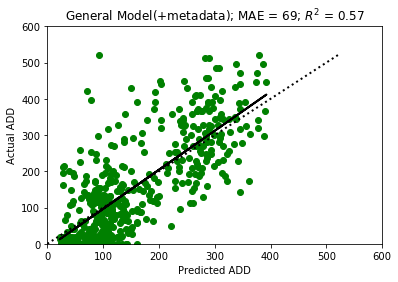

In [22]:
plt.scatter(yhat, y_val, color = 'g')
lower = np.min(np.concatenate([y_val, yhat]))
upper = np.max(np.concatenate([y_val, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_val)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('General Model(+metadata); MAE = %d; $R^2$ = %.2f' %(MAE,round(model_PMI3_allMetab_general_rfecv.score(X_val,y_val),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/general_model_validation.png')